In [1]:
import os
SNAPPY_notebook_path = os.path.join(os.path.abspath(""), "bench.ipynb")

In [2]:
import time
SNAPPY_start_time = time.perf_counter_ns()

In [3]:
%load_ext autotime

time: 62.1 µs (started: 2024-05-07 14:49:47 -04:00)


In [4]:
import os
# STEFANOS: Conditionally import Modin Pandas
import pandas as pd
import numpy as np 
df1=pd.read_csv(os.path.abspath('') + '/input/tmdb-movie-metadata/tmdb_5000_credits.csv')
df2=pd.read_csv(os.path.abspath('') + '/input/tmdb-movie-metadata/tmdb_5000_movies.csv')

time: 500 ms (started: 2024-05-07 14:49:47 -04:00)


# -- STEFANOS -- Replicate Data
The `literal_eval` takes a lot of time with this replication but with lower replication everything else is just noise.

In [5]:
factor = 50
if "IREWR_LESS_REPLICATION" in os.environ and os.environ["IREWR_LESS_REPLICATION"] == "True":
    factor = factor//3
df1 = pd.concat([df1]*factor, ignore_index=True)
# df1.info()

time: 4.29 ms (started: 2024-05-07 14:49:47 -04:00)


In [6]:
df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')

time: 57.1 ms (started: 2024-05-07 14:49:47 -04:00)


Just a peak at our data.

In [7]:
df2.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
2,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
3,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
4,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


time: 14.9 ms (started: 2024-05-07 14:49:47 -04:00)


# **Demographic Filtering** -
   Before getting started with this  -
* we need a metric to score or rate movie 
* Calculate the score for every movie 
* Sort the scores and recommend the best rated movie to the users.

We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes.
So, I'll be using IMDB's weighted rating (wr) which is given as :-

![](https://image.ibb.co/jYWZp9/wr.png)
where,
* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

We already have v(**vote_count**) and R (**vote_average**) and C can be calculated as 

In [8]:
C= df2['vote_average'].mean()
C

6.092171559442017

time: 2.49 ms (started: 2024-05-07 14:49:47 -04:00)


So, the mean rating for all the movies is approx 6 on a scale of 10.The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.

In [9]:
m= df2['vote_count'].quantile(0.9)
m

1840.0

time: 11.2 ms (started: 2024-05-07 14:49:47 -04:00)


Now, we can filter out the movies that qualify for the chart 

In [10]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape

(24050, 23)

time: 65.7 ms (started: 2024-05-07 14:49:47 -04:00)


We see that there are 481 movies which qualify to be in this list. Now, we need to calculate our metric for each qualified movie. To do this, we will define a function, **weighted_rating()** and define a new feature **score**, of which we'll calculate the value by applying this function to our DataFrame of qualified movies:

In [11]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

time: 297 µs (started: 2024-05-07 14:49:47 -04:00)


In [12]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

time: 156 ms (started: 2024-05-07 14:49:47 -04:00)


Finally, let's sort the DataFrame based on the score feature and output the title, vote count, vote average and weighted rating or score of the top 10 movies.

In [13]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
94074,The Shawshank Redemption,8205,8.5,8.058944
94079,The Shawshank Redemption,8205,8.5,8.058944
94077,The Shawshank Redemption,8205,8.5,8.058944
94076,The Shawshank Redemption,8205,8.5,8.058944
94075,The Shawshank Redemption,8205,8.5,8.058944
94073,The Shawshank Redemption,8205,8.5,8.058944
94072,The Shawshank Redemption,8205,8.5,8.058944
94071,The Shawshank Redemption,8205,8.5,8.058944
94070,The Shawshank Redemption,8205,8.5,8.058944
94069,The Shawshank Redemption,8205,8.5,8.058944


time: 8.33 ms (started: 2024-05-07 14:49:48 -04:00)


Hurray! We have made our first(though very basic) recommender.
Under the **Trending Now** tab of these systems we find movies that are very popular and they can just be obtained by sorting the dataset by the popularity column.

In [14]:
pop= df2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
# STEFANOS: Disable plotting
# plt.figure(figsize=(12,4))

# plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
#         color='skyblue')
# plt.gca().invert_yaxis()
# plt.xlabel("Popularity")
# plt.title("Popular Movies")


time: 255 ms (started: 2024-05-07 14:49:48 -04:00)


Now something to keep in mind is that these demographic recommender provide a general chart of recommended movies to all the users. They are not sensitive to the interests and tastes of a particular user.
This is when we move on to a more refined system-  Content Basesd Filtering. 

# **Content Based Filtering**
In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

![](https://image.ibb.co/f6mDXU/conten.png)

## **Plot description based Recommender**

We will compute pairwise similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score. The plot description is given in the **overview** feature of our dataset. 
Let's take a look at the data. .. 

In [15]:
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    In the 22nd century, a paraplegic Marine is di...
2    In the 22nd century, a paraplegic Marine is di...
3    In the 22nd century, a paraplegic Marine is di...
4    In the 22nd century, a paraplegic Marine is di...
Name: overview, dtype: object

time: 1.94 ms (started: 2024-05-07 14:49:48 -04:00)


For any of you who has done even a  bit of text processing before knows we need to convert the word vector of each overview.
Now we'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

Now if you are wondering what is term frequency , it is the relative frequency of a word in a document and is given as
   **(term instances/total instances)**.
Inverse Document Frequency is the relative count of documents containing the term is given as 
**log(number of documents/documents with term)**
The overall importance of each word to the documents in which they appear is equal to **TF * IDF**

This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each row represents a movie, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

Fortunately, scikit-learn gives you a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines. That's great, isn't it? 

In [16]:
#Import TfIdfVectorizer from scikit-learn
# STEFANOS: Remove unneeded modules.
# from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
# STEFANOS: non-Pandas. The code that uses it is disabled.
# tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df2['overview'] = df2['overview'].fillna('')

# STEFANOS: non-Pandas. The code that uses it is disabled.
# #Construct the required TF-IDF matrix by fitting and transforming the data
# tfidf_matrix = tfidf.fit_transform(df2['overview'])

# #Output the shape of tfidf_matrix
# tfidf_matrix.shape

time: 17.6 ms (started: 2024-05-07 14:49:48 -04:00)


We see that over 20,000 different words were used to describe the 4800 movies in our dataset.

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the [cosine similarity scores](https://en.wikipedia.org/wiki/Cosine_similarity). There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:
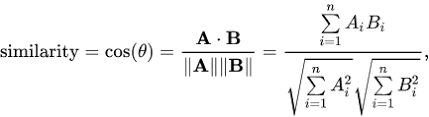

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's **linear_kernel()** instead of cosine_similarities() since it is faster.

In [17]:
# STEFANOS: This takes an inordinate amount of memory and it's not Pandas.
# Because we're not using get_recommendations(), we're fine

# # Import linear_kernel
# from sklearn.metrics.pairwise import linear_kernel

# # Compute the cosine similarity matrix
# cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

time: 4.36 ms (started: 2024-05-07 14:49:48 -04:00)


We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [18]:
#Construct a reverse map of indices and movie titles
# STEFANOS: Don't drop duplicates.
# indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

time: 10.2 ms (started: 2024-05-07 14:49:48 -04:00)


We are now in a good position to define our recommendation function. These are the following steps we'll follow :-
* Get the index of the movie given its title.
* Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
* Return the titles corresponding to the indices of the top elements.

In [19]:
# Function that takes in movie title as input and outputs most similar movies

# STEFANOS: get_recommendations() fails to run sometimes and it's not Pandas
# def get_recommendations(title, cosine_sim=cosine_sim):
#     # Get the index of the movie that matches the title
#     idx = indices[title]

#     # Get the pairwsie similarity scores of all movies with that movie
#     sim_scores = list(enumerate(cosine_sim[idx]))

#     # Sort the movies based on the similarity scores
#     # STEFANOS: This doesn't run
# #     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#     sim_scores = sorted(sim_scores, key=lambda x: x[1].any(), reverse=True)

#     # Get the scores of the 10 most similar movies
#     sim_scores = sim_scores[1:11]

#     # Get the movie indices
#     movie_indices = [i[0] for i in sim_scores]

#     # Return the top 10 most similar movies
#     return df2['title'].iloc[movie_indices]

time: 11 ms (started: 2024-05-07 14:49:48 -04:00)


In [20]:
# STEFANOS: get_recommendations() fails to run sometimes and it's not Pandas
# get_recommendations('The Dark Knight Rises')

time: 12.9 ms (started: 2024-05-07 14:49:48 -04:00)


In [21]:
# STEFANOS: get_recommendations() fails to run sometimes and it's not Pandas
# get_recommendations('The Avengers')

time: 10.3 ms (started: 2024-05-07 14:49:48 -04:00)


While our system has done a decent job of finding movies with similar plot descriptions, the quality of recommendations is not that great. "The Dark Knight Rises" returns all Batman movies while it is more likely that the people who liked that movie are more inclined to enjoy other Christopher Nolan movies. This is something that cannot be captured by the present system.

## **Credits, Genres and Keywords Based Recommender**
It goes without saying that the quality of our recommender would be increased with the usage of better metadata. That is exactly what we are going to do in this section. We are going to build a recommender based on the following metadata: the 3 top actors, the director, related genres and the movie plot keywords.

From the cast, crew and keywords features, we need to extract the three most important actors, the director and the keywords associated with that movie. Right now, our data is present in the form of "stringified" lists , we need to convert it into a safe and usable structure

In [22]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

time: 4min 42s (started: 2024-05-07 14:49:48 -04:00)


Next, we'll write functions that will help us to extract the required information from each feature.

In [23]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

time: 332 µs (started: 2024-05-07 14:54:30 -04:00)


In [24]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

time: 8.25 ms (started: 2024-05-07 14:54:30 -04:00)


In [25]:
# Define new director, cast, genres and keywords features that are in a suitable form.
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)

time: 4.74 s (started: 2024-05-07 14:54:30 -04:00)


In [26]:
# Print the new features of the first 3 films
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
2,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"


time: 23.3 ms (started: 2024-05-07 14:54:35 -04:00)


The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.

In [27]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

time: 340 µs (started: 2024-05-07 14:54:35 -04:00)


In [28]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

time: 2.31 s (started: 2024-05-07 14:54:35 -04:00)


We are now in a position to create our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer (namely actors, director and keywords).

In [29]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)

time: 2.31 s (started: 2024-05-07 14:54:37 -04:00)


The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the **CountVectorizer()** instead of TF-IDF. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.

In [30]:
SNAPPY_end_time = time.perf_counter_ns()
print("Total elapsed time:", (SNAPPY_end_time - SNAPPY_start_time) / (10 ** 9))

Total elapsed time: 293.051750551
time: 313 µs (started: 2024-05-07 14:54:40 -04:00)


# -- STEFANOS -- Disable all the rest because it's non-Pandas